In [1]:
import gc

import re

import pandas as pd
#import modin.pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from cycler import cycler

import multiprocessing as mp

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity
#unit_parser = np.vectorize(lambda x : Q_(x).to_base_units().magnitude)

In [2]:
def parse_if_number(s):
    try: 
        return float(s)
    except: 
        try:
            return Q_(s).to_base_units().magnitude
        except:
            return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    result = None
    
    if s:
        return np.fromstring(s, sep=' ')
    else:
        return None

def parse_string(s):
    if s:
        return s
    else:
        return None

class LazyEval:
    
    def __init__(self, evalFunc, s):
        self.evalFunc = evalFunc
        self.s = s
        self.value = None
    
    def evaluate(self):
        if self.value is None:
            self.value = self.evalFunc(self.s)
        
        return self.value

In [3]:
select_columns = ['run', 'type', 'module', 'name', 'attrname', 'attrvalue', 'value', 'vectime', 'vecvalue']
out_columns = select_columns

runs = 10
samplingRate = 100
queueSize = 6

def reduce_hist(x):
    result = np.add.reduce(x.values) / x.size
    result /= np.add.reduce(result)
    
    return result.tolist()

def filter_chunk(chunk):
    cvars = chunk.loc[
        (chunk.type == 'itervar') 
        | (chunk.type == 'runattr') 
        | (chunk.type == 'scalar'), 
        select_columns]
    # add created columns to enable frictionless concat
    #cvars['hist'] = None
    vectors = chunk[(chunk.type == 'vector') 
                    #& ((chunk.name == 'ctrlTargetQM:vector') # end host target QM
                    & ((chunk.name == 'coccAppliedQM:vector') # end host target QM
                       |(chunk.name == 'act_delay_ca:vector') # end host e2e delay
                       |((chunk.module.str.startswith('FourHopNcs.ncs')) 
                         & (chunk.name == 'ppp0-bitrate:vector')) # end host bitrate
                       |(chunk.module.str.startswith('FourHopNcs.ic1') #ic1 queue
                        &(chunk.name.str.contains(r'ppp0-(?:ctrlL)?BE-qLength:vector')))
                       |(chunk.module.str.contains('FourHopNcs.ic[23]') #ic2,3 queue
                        &(chunk.name.str.contains(r'ppp1-(?:ctrlL)?BE-qLength:vector')))
                      )]
    rows = []
    
    for row in vectors.itertuples():
        name = None
        value = None
        
        masked_vecvalue = np.ma.array(
            row.vecvalue.evaluate(), 
            mask=(row.vectime.evaluate() < 30)
        ).compressed()
        
        if row.name == 'coccAppliedQM:vector':#'ctrlTargetQM:vector':
            name = 'ctrlTargetQM'
            value = masked_vecvalue
        if row.name == 'act_delay_ca:vector':
            name = 'act_delay_ca'
            value = masked_vecvalue
        if row.name == 'ppp0-bitrate:vector':
            name = 'ctrlBitrate'
            value = masked_vecvalue
        if re.search(r'ppp[01]-BE-qLength:vector', row.name):
            name = 'bnBEQueue'
            value = masked_vecvalue
        if re.search(r'ppp[01]-ctrlLBE-qLength:vector', row.name):
            name = 'bnLBEQueue'
            value = masked_vecvalue

        r_new = [ 
            row.run, 
            row.type, 
            row.module, 
            name, 
            row.attrname,
            row.attrvalue,
            value,
            row.vectime.evaluate(),
            row.vecvalue.evaluate()
        ]
        rows.append(r_new)
            
    result = pd.concat([cvars, pd.DataFrame(data=rows, columns=out_columns)])
    
    return(result)

In [4]:
csv_prefix = '../results-fourhop/'

iterator = pd.read_csv(csv_prefix + 'MultiBottleneck_Mock_Manyflows1.csv.xz', chunksize=20, converters = {
    'attrname' : parse_string,
    'attrvalue': parse_if_number,
    'binedges': lambda x : LazyEval(parse_ndarray, x),
    'binvalues': lambda x : LazyEval(parse_ndarray, x),
    'module' : parse_string,
    'name' : parse_string,
    'vectime': lambda x : LazyEval(parse_ndarray, x),
    'vecvalue': lambda x : LazyEval(parse_ndarray, x)})

data_chunks = []
pool = mp.Pool(processes=2)

print('reading data in chunks')

for chunk in iterator:
    chunk_result = pool.apply_async(filter_chunk, [chunk])
    #chunk_result = filter_chunk(chunk)
    data_chunks.append(chunk_result)

pool.close()
pool.join()

print('concatenating chunked data')

data = pd.concat((chunk.get() for chunk in data_chunks), ignore_index=True)
#data = pd.concat((chunk for chunk in data_chunks), ignore_index=True)

#display(data)
display(data.head())
display(data.tail())

reading data in chunks
concatenating chunked data


,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
0,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,runattr,None,None,configname,MultiBottleneck_Mock_Manyflows1,NaN,<__main__.LazyEval object at 0x7fd01535b908>,<__main__.LazyEval object at 0x7fd01535b4a8>
1,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,runattr,None,None,datetime,20205782,NaN,<__main__.LazyEval object at 0x7fd01535b8d0>,<__main__.LazyEval object at 0x7fd01535b208>
2,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,runattr,None,None,experiment,MultiBottleneck_Mock_Manyflows1,NaN,<__main__.LazyEval object at 0x7fd01535b898>,<__main__.LazyEval object at 0x7fd01535b2b0>
3,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,runattr,None,None,inifile,/mnt/data/Projekte/SPP1914_CPN/code/ncs-testbe...,NaN,<__main__.LazyEval object at 0x7fd01535b860>,<__main__.LazyEval object at 0x7fd01535b278>
4,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,runattr,None,None,iterationvars,"$ccMode=1, $collectionInterval=0.05, $bottlene...",NaN,<__main__.LazyEval object at 0x7fd01535b828>,<__main__.LazyEval object at 0x7fd01535b240>


,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
2516,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,vector,FourHopNcs.ncs34[216].ncsContext,act_delay_ca,None,None,"[0.000805342516, 0.000451154946, 0.00031026724...","[36.0855176476, 36.1134120476, 36.1330451712, ...","[0.000805342516, 0.000451154946, 0.00031026724..."
2517,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,vector,FourHopNcs.ncs34[237].ncsContext,act_delay_ca,None,None,"[0.000842690356, 0.000342562049, 0.00051769417...","[36.0855824476, 36.1116523676, 36.128735712284...","[0.000842690356, 0.000342562049, 0.00051769417..."
2518,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,vector,FourHopNcs.ncs34[246].ncsContext,act_delay_ca,None,None,"[0.000849760576, 0.000559853552, 0.00066624472...","[36.0857482876, 36.1124854076, 36.126105312284...","[0.000849760576, 0.000559853552, 0.00066624472..."
2519,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,vector,FourHopNcs.ncs34[204].ncsContext,act_delay_ca,None,None,"[0.001092558544, 0.000391377664, 0.00048088264...","[36.0868194076, 36.1175647676, 36.1396668512, ...","[0.001092558544, 0.000391377664, 0.00048088264..."
2520,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,vector,FourHopNcs.ncs34[198].ncsContext,act_delay_ca,None,None,"[0.001051827604, 0.000138813541, 0.00027628454...","[36.0876313276, 36.120051646867, 36.1435224512...","[0.001051827604, 0.000138813541, 0.00027628454..."


In [5]:
scalars = data[data.type=='scalar']
vectors = data[data.type=='vector']

print(len(scalars))
len(vectors)

244


2256

In [6]:
%xdel -n data
data = None

gc.collect()

0

In [7]:
scalars.head()
vectors.head()

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
265,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,vector,FourHopNcs.ncs12[0].controller.monitoringColle...,ctrlBitrate,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
266,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,vector,FourHopNcs.ncs12[1].controller.monitoringColle...,ctrlBitrate,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
267,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,vector,FourHopNcs.ncs12[2].controller.monitoringColle...,ctrlBitrate,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
268,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,vector,FourHopNcs.ncs12[3].controller.monitoringColle...,ctrlBitrate,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
269,MultiBottleneck_Mock_Manyflows1-0-20210722-10:...,vector,FourHopNcs.ncs12[4].controller.monitoringColle...,ctrlBitrate,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
#for col in vectors.columns:
#    print(col)
scalars.name.unique(), vectors.name.unique(), vectors.module.unique()

(array(['dropPk:count', 'dropPk:sum(packetBytes)', 'queueLength:max',
        'queueLength:timeavg', 'rcvdPk:count', 'rcvdPk:sum(packetBytes)',
        'txState:timeavg', 'droppedPkIfaceDown:count',
        'droppedPkIfaceDown:sum(packetBytes)', 'droppedPkBitError:count',
        'droppedPkBitError:sum(packetBytes)', 'rxPkOk:count',
        'rxPkOk:sum(packetBytes)', 'txPk:count', 'txPk:sum(packetBytes)',
        'rcvdPkFromHL:count', 'rcvdPkFromHL:sum(packetBytes)',
        'passedUpPk:count', 'passedUpPk:sum(packetBytes)'], dtype=object),
 array(['ctrlBitrate', 'bnBEQueue', 'ctrlTargetQM', 'act_delay_ca',
        'bnLBEQueue'], dtype=object),
 array(['FourHopNcs.ncs12[0].controller.monitoringCollector',
        'FourHopNcs.ncs12[1].controller.monitoringCollector',
        'FourHopNcs.ncs12[2].controller.monitoringCollector', ...,
        'FourHopNcs.ncs34[246].ncsContext',
        'FourHopNcs.ncs34[204].ncsContext',
        'FourHopNcs.ncs34[198].ncsContext'], dtype=object))

In [9]:
np.floor_divide(0.149, 0.05) * 0.05

0.1

In [10]:
time_series_qm = pd.DataFrame()
time_series_rate = pd.DataFrame()
time_series_delay = pd.DataFrame()
time_series_queue = pd.DataFrame()

hop_list = ["ncs12","ncs23","ncs34","ncs14"]
ic_list = ["ic1","ic2","ic3"]
module_list = hop_list + ic_list
name_list = vectors.name.unique()

#pool = mp.Pool(processes=2)

#for chunk in iterator:
#    chunk_result = pool.apply_async(filter_chunk, [chunk])
#    data_chunks.append(chunk_result)

#pool.close()
#pool.join()
    
qm_list = []
rate_list = []
delay_list = []
queue_list = []

print("splitting")

for row in vectors.itertuples():
    rowGroup = None
    for candidate in module_list:
        if re.search(candidate, row.module):
            rowGroup = candidate
    if rowGroup is None:
        print("WARNING: unable to match " + row.module)
    
    column = (rowGroup, row.module + '.' + row.name)
    
    rowFrame = pd.DataFrame(
        {column : row.vecvalue}, 
        index=row.vectime,
        columns=[column]
    )
    rowFrame = rowFrame[(rowFrame.index >= 30)]
    
    if row.name == 'ctrlTargetQM': #by hop
        #filter timestamps which do not match 50ms + 10ms grid
        #mappedIndex = rowFrame.index.map(lambda x: np.floor_divide(x - 0.01, 0.05) * 0.05 + 0.01)
        #duplicates = mappedIndex.duplicated(keep='first')
        #rowFrame = rowFrame[~duplicates]
        
        qm_list.append(rowFrame)
    if row.name == 'ctrlBitrate': #by hop
        rate_list.append(rowFrame)
    if row.name == 'act_delay_ca': #by hop
        delay_list.append(rowFrame)
    if row.name == 'bnBEQueue': #by ic
        queue_list.append(rowFrame)
    if row.name == 'bnLBEQueue': #by ic
        queue_list.append(rowFrame)

#display(qm_list)
        
print("joining 1/4")
time_series_qm = time_series_qm.join(qm_list, how='outer')
%xdel -n qm_list
qm_list = None
print("joining 2/4")
time_series_rate = time_series_rate.join(rate_list, how='outer')
%xdel -n rate_list
rate_list = None
print("joining 3/4")
time_series_delay = time_series_delay.join(delay_list, how='outer')
%xdel -n delay_list
delay_list = None
print("joining 4/4")
time_series_queue = time_series_queue.join(queue_list, how='outer')
%xdel -n queue_list
queue_list = None


time_series_qm = time_series_qm.reindex(sorted(time_series_qm.columns), axis=1)
time_series_rate = time_series_rate.reindex(sorted(time_series_rate.columns), axis=1)
time_series_delay = time_series_delay.reindex(sorted(time_series_delay.columns), axis=1)
time_series_queue = time_series_queue.reindex(sorted(time_series_queue.columns), axis=1)

time_series_qm.columns = pd.MultiIndex.from_tuples(time_series_qm.columns, names=["group", "name"])
time_series_rate.columns = pd.MultiIndex.from_tuples(time_series_rate.columns, names=["group", "name"])
time_series_delay.columns = pd.MultiIndex.from_tuples(time_series_delay.columns, names=["group", "name"])
time_series_queue.columns = pd.MultiIndex.from_tuples(time_series_queue.columns, names=["group", "name"])

display(time_series_qm)
display(time_series_rate)
display(time_series_delay)
display(time_series_queue)


%xdel -n vectors
vectors = None
rowFrame = None

gc.collect()

splitting
joining 1/4
joining 2/4
joining 3/4
joining 4/4


group                                            ncs12  \
name  FourHopNcs.ncs12[0].controller.coCC.ctrlTargetQM   
30.01                                              NaN   
30.06                                              NaN   
30.11                                              NaN   
30.16                                              NaN   
30.21                                              NaN   
...                                                ...   
43.76                                              NaN   
43.81                                              NaN   
43.86                                              NaN   
43.91                                              NaN   
43.96                                              NaN   

group                                                     \
name  FourHopNcs.ncs12[100].controller.coCC.ctrlTargetQM   
30.01                                                NaN   
30.06                                                NaN   
30.11                                                NaN   
30.16                                                NaN   
30.21                                                NaN   
...                                                  ...   
43.76                                                NaN   
43.81                                                NaN   
43.86                                                NaN   
43.91                                                NaN   
43.96                                                NaN   

group                                                     \
name  FourHopNcs.ncs12[101].controller.coCC.ctrlTargetQM   
30.01                                                NaN   
30.06                                                NaN   
30.11                                                NaN   
30.16                                                NaN   
30.21                                                NaN   
...                                                  ...   
43.76                                                NaN   
43.81                                                NaN   
43.86                                                NaN   
43.91                                                NaN   
43.96                                                NaN   

group                                                     \
name  FourHopNcs.ncs12[102].controller.coCC.ctrlTargetQM   
30.01                                                NaN   
30.06                                                NaN   
30.11                                                NaN   
30.16                                                NaN   
30.21                                                NaN   
...                                                  ...   
43.76                                                NaN   
43.81                                                NaN   
43.86                                                NaN   
43.91                                                NaN   
43.96                                                NaN   

group                                                     \
name  FourHopNcs.ncs12[103].controller.coCC.ctrlTargetQM   
30.01                                                NaN   
30.06                                                NaN   
30.11                                                NaN   
30.16                                                NaN   
30.21                                                NaN   
...                                                  ...   
43.76                                                NaN   
43.81                                                NaN   
43.86                                                NaN   
43.91                                                NaN   
43.96                                                NaN   

group                                                     \
name  FourHopNcs.ncs12[104].controller.coCC.ctrlTargetQM   
3

group                                                          ncs12  \
name  FourHopNcs.ncs12[0].controller.monitoringCollector.ctrlBitrate   
30.00                                                0.0               
30.05                                                0.0               
30.10                                                0.0               
30.15                                                0.0               
30.20                                                0.0               
...                                                  ...               
43.80                                                0.0               
43.85                                                0.0               
43.90                                                0.0               
43.95                                                0.0               
44.00                                                0.0               

group                                                                   \
name  FourHopNcs.ncs12[100].controller.monitoringCollector.ctrlBitrate   
30.00                                                0.0                 
30.05                                                0.0                 
30.10                                                0.0                 
30.15                                                0.0                 
30.20                                                0.0                 
...                                                  ...                 
43.80                                                0.0                 
43.85                                                0.0                 
43.90                                                0.0                 
43.95                                                0.0                 
44.00                                                0.0                 

group                                                                   \
name  FourHopNcs.ncs12[101].controller.monitoringCollector.ctrlBitrate   
30.00                                                0.0                 
30.05                                                0.0                 
30.10                                                0.0                 
30.15                                                0.0                 
30.20                                                0.0                 
...                                                  ...                 
43.80                                                0.0                 
43.85                                                0.0                 
43.90                                                0.0                 
43.95                                                0.0                 
44.00                                                0.0                 

group                                                                   \
name  FourHopNcs.ncs12[102].controller.monitoringCollector.ctrlBitrate   
30.00                                                0.0                 
30.05                                                0.0                 
30.10                                                0.0                 
30.15                                                0.0                 
30.20                                                0.0                 
...                                                  ...                 
43.80                                                0.0                 
43.85                                                0.0                 
43.90                                                0.0                 
43.95                                                0.0                 
44.00                                                0.0                 

group                                                                   \
name  FourHopNcs.ncs12[103].controller.monitoringCollector.ctrlBitrate   
30.00                     

group                                           ncs12  \
name      FourHopNcs.ncs12[0].ncsContext.act_delay_ca   
30.010198                                         NaN   
30.012181                                         NaN   
30.012458                                         NaN   
30.012649                                         NaN   
30.013160                                         NaN   
...                                               ...   
43.999854                                         NaN   
43.999886                                         NaN   
43.999919                                         NaN   
43.999951                                         NaN   
43.999983                                         NaN   

group                                                    \
name      FourHopNcs.ncs12[100].ncsContext.act_delay_ca   
30.010198                                           NaN   
30.012181                                           NaN   
30.012458                                           NaN   
30.012649                                           NaN   
30.013160                                           NaN   
...                                                 ...   
43.999854                                           NaN   
43.999886                                           NaN   
43.999919                                           NaN   
43.999951                                           NaN   
43.999983                                           NaN   

group                                                    \
name      FourHopNcs.ncs12[101].ncsContext.act_delay_ca   
30.010198                                           NaN   
30.012181                                           NaN   
30.012458                                           NaN   
30.012649                                           NaN   
30.013160                                           NaN   
...                                                 ...   
43.999854                                           NaN   
43.999886                                           NaN   
43.999919                                           NaN   
43.999951                                           NaN   
43.999983                                           NaN   

group                                                    \
name      FourHopNcs.ncs12[102].ncsContext.act_delay_ca   
30.010198                                           NaN   
30.012181                                           NaN   
30.012458                                           NaN   
30.012649                                           NaN   
30.013160                                           NaN   
...                                                 ...   
43.999854                                           NaN   
43.999886                                           NaN   
43.999919                                           NaN   
43.999951                                           NaN   
43.999983                                           NaN   

group                                                    \
name      FourHopNcs.ncs12[103].ncsContext.act_delay_ca   
30.010198                                           NaN   
30.012181                                           NaN   
30.012458                                           NaN   
30.012649                                           NaN   
30.013160                                           NaN   
...                                                 ...   
43.999854                                           NaN   
43.999886                                           NaN   
43.999919                                           NaN   
43.999951                                           NaN   
43.999983                                           NaN   

group                                                    \
name      FourHopNcs.ncs12[104].ncsContext.act_delay_ca   
30.010198                                           NaN   
30.012181

group                                          ic1  \
name  FourHopNcs.ic1.monitoringCollector.bnBEQueue   
30.00                                          0.0   
30.05                                          0.0   
30.10                                          0.0   
30.15                                          0.0   
30.20                                          0.0   
...                                            ...   
43.80                                          0.0   
43.85                                          0.0   
43.90                                          0.0   
43.95                                          0.0   
44.00                                          0.0   

group                                                \
name  FourHopNcs.ic1.monitoringCollector.bnLBEQueue   
30.00                                           NaN   
30.05                                      0.000311   
30.10                                      5.594480   
30.15                                     14.344685   
30.20                                      8.493090   
...                                             ...   
43.80                                      8.244459   
43.85                                      8.186651   
43.90                                      5.418184   
43.95                                      6.916711   
44.00                                      6.144843   

group                                          ic2  \
name  FourHopNcs.ic2.monitoringCollector.bnBEQueue   
30.00                                          0.0   
30.05                                          0.0   
30.10                                          0.0   
30.15                                          0.0   
30.20                                          0.0   
...                                            ...   
43.80                                          0.0   
43.85                                          0.0   
43.90                                          0.0   
43.95                                          0.0   
44.00                                          0.0   

group                                                \
name  FourHopNcs.ic2.monitoringCollector.bnLBEQueue   
30.00                                           NaN   
30.05                                      0.000001   
30.10                                      0.018834   
30.15                                      0.039209   
30.20                                      0.025389   
...                                             ...   
43.80                                      0.013516   
43.85                                      0.014089   
43.90                                      0.018287   
43.95                                      0.019544   
44.00                                      0.009905   

group                                          ic3  \
name  FourHopNcs.ic3.monitoringCollector.bnBEQueue   
30.00                                          0.0   
30.05                                          0.0   
30.10                                          0.0   
30.15                                          0.0   
30.20                                          0.0   
...                                            ...   
43.80                                          0.0   
43.85                                          0.0   
43.90                                          0.0   
43.95                                          0.0   
44.00                                          0.0   

group                                                
name  FourHopNcs.ic3.monitoringCollector.bnLBEQueue  
30.00                                           NaN  
30.05                                      0.000002  
30.10                                      0.018912  
30.15                                      0.039169  
30.20                                      0.025428  
...                                             ...  
43.80                      

0

In [11]:
def aggregatePerHop(df, function):
    indexTemplate = pd.DataFrame([0]).apply(function)
    aggIndex = pd.MultiIndex.from_product([df.columns.levels[0], indexTemplate.index.values], names=df.columns.names)
    aggSeries = pd.DataFrame(index=df.index,columns=aggIndex)

    for hop in df.columns.levels[0]:
        aggSeries[hop] = df[hop].apply(function, axis=1)
        
    return aggSeries

print("aggregating QM")
aggQM = aggregatePerHop(time_series_qm, pd.DataFrame.describe)
print("aggregating rate")
aggRate = aggregatePerHop(time_series_rate, pd.DataFrame.sum)

display(aggQM)
display(aggRate)

print("aggregating delays")
indexTemplate = pd.DataFrame([0]).describe()
dcolindex = pd.MultiIndex.from_product([time_series_delay.columns.levels[0], indexTemplate.index.values], names=time_series_delay.columns.names)
aggDelay = pd.DataFrame(columns=dcolindex)

aggLines = []

for start in np.arange(np.floor_divide(time_series_delay.index.min(), 0.05)*0.05, time_series_delay.index.max(), 0.05):
    end = start + 0.05
    
    aggLine = []
    
    for hop in time_series_delay.columns.levels[0]:
        rawData = time_series_delay.loc[start:end,(hop, slice(None))].to_numpy().flatten()
        rdf = pd.DataFrame(rawData)
        aggLine.append(rdf.describe().transpose().rename({0 : start}))
    
    try:
        aggLines.append(pd.concat(aggLine, axis=1, keys=time_series_delay.columns.levels[0]))
    except ValueError as e:
        display(aggLine)
        raise

aggDelay = aggDelay.append(aggLines)
aggLines = None
aggLine = None
display(aggDelay)

print("aggregating queue")
for hop in time_series_queue.columns.levels[0]:
    time_series_queue[hop,"sum"] = time_series_queue[hop].sum(axis=1)

display(time_series_queue)

%xdel -n time_series_qm
time_series_qm = None
%xdel -n time_series_delay
time_series_delay = None
%xdel -n time_series_delay
time_series_delay = None
%xdel -n time_series_delay
time_series_delay = None

gc.collect()

aggregating QM
aggregating rate


group ncs12                               ncs14            ... ncs23      \
name  count mean std min 25% 50% 75% max  count      mean  ...   75% max   
30.01   0.0  NaN NaN NaN NaN NaN NaN NaN  150.0  0.780000  ...   NaN NaN   
30.06   0.0  NaN NaN NaN NaN NaN NaN NaN  150.0  0.998879  ...   NaN NaN   
30.11   0.0  NaN NaN NaN NaN NaN NaN NaN  150.0  0.998885  ...   NaN NaN   
30.16   0.0  NaN NaN NaN NaN NaN NaN NaN  150.0  0.998999  ...   NaN NaN   
30.21   0.0  NaN NaN NaN NaN NaN NaN NaN  150.0  0.998999  ...   NaN NaN   
...     ...  ...  ..  ..  ..  ..  ..  ..    ...       ...  ...   ...  ..   
43.76   0.0  NaN NaN NaN NaN NaN NaN NaN  150.0  0.998999  ...   NaN NaN   
43.81   0.0  NaN NaN NaN NaN NaN NaN NaN  150.0  0.998999  ...   NaN NaN   
43.86   0.0  NaN NaN NaN NaN NaN NaN NaN  150.0  0.998999  ...   NaN NaN   
43.91   0.0  NaN NaN NaN NaN NaN NaN NaN  150.0  0.998999  ...   NaN NaN   
43.96   0.0  NaN NaN NaN NaN NaN NaN NaN  150.0  0.998999  ...   NaN NaN   

group ncs34                               
name  count mean std min 25% 50% 75% max  
30.01   0.0  NaN NaN NaN NaN NaN NaN NaN  
30.06   0.0  NaN NaN NaN NaN NaN NaN NaN  
30.11   0.0  NaN NaN NaN NaN NaN NaN NaN  
30.16   0.0  NaN NaN NaN NaN NaN NaN NaN  
30.21   0.0  NaN NaN NaN NaN NaN NaN NaN  
...     ...  ...  ..  ..  ..  ..  ..  ..  
43.76   0.0  NaN NaN NaN NaN NaN NaN NaN  
43.81   0.0  NaN NaN NaN NaN NaN NaN NaN  
43.86   0.0  NaN NaN NaN NaN NaN NaN NaN  
43.91   0.0  NaN NaN NaN NaN NaN NaN NaN  
43.96   0.0  NaN NaN NaN NaN NaN NaN NaN  

[280 rows x 32 columns]

group,ncs12,ncs14,ncs23,ncs34
name,0,0,0,0
30.00,0.0,1.896000e+06,0.0,0.0
30.05,0.0,3.341200e+07,0.0,0.0
30.10,0.0,9.330480e+07,0.0,0.0
30.15,0.0,9.918113e+07,0.0,0.0
30.20,0.0,9.900913e+07,0.0,0.0
...,...,...,...,...
43.80,0.0,9.852369e+07,0.0,0.0
43.85,0.0,9.945183e+07,0.0,0.0
43.90,0.0,9.834963e+07,0.0,0.0


aggregating delays


group ncs12                                ncs14            ... ncs23      \
name  count mean std min 25% 50% 75% max   count      mean  ...   75% max   
30.00   0.0  NaN NaN NaN NaN NaN NaN NaN   489.0  0.000181  ...   NaN NaN   
30.05   0.0  NaN NaN NaN NaN NaN NaN NaN  1426.0  0.000359  ...   NaN NaN   
30.10   0.0  NaN NaN NaN NaN NaN NaN NaN  1524.0  0.000636  ...   NaN NaN   
30.15   0.0  NaN NaN NaN NaN NaN NaN NaN  1512.0  0.000445  ...   NaN NaN   
30.20   0.0  NaN NaN NaN NaN NaN NaN NaN  1524.0  0.000425  ...   NaN NaN   
...     ...  ...  ..  ..  ..  ..  ..  ..     ...       ...  ...   ...  ..   
43.75   0.0  NaN NaN NaN NaN NaN NaN NaN  1517.0  0.000437  ...   NaN NaN   
43.80   0.0  NaN NaN NaN NaN NaN NaN NaN  1521.0  0.000432  ...   NaN NaN   
43.85   0.0  NaN NaN NaN NaN NaN NaN NaN  1515.0  0.000345  ...   NaN NaN   
43.90   0.0  NaN NaN NaN NaN NaN NaN NaN  1522.0  0.000390  ...   NaN NaN   
43.95   0.0  NaN NaN NaN NaN NaN NaN NaN  1518.0  0.000367  ...   NaN NaN   

group ncs34                               
name  count mean std min 25% 50% 75% max  
30.00   0.0  NaN NaN NaN NaN NaN NaN NaN  
30.05   0.0  NaN NaN NaN NaN NaN NaN NaN  
30.10   0.0  NaN NaN NaN NaN NaN NaN NaN  
30.15   0.0  NaN NaN NaN NaN NaN NaN NaN  
30.20   0.0  NaN NaN NaN NaN NaN NaN NaN  
...     ...  ...  ..  ..  ..  ..  ..  ..  
43.75   0.0  NaN NaN NaN NaN NaN NaN NaN  
43.80   0.0  NaN NaN NaN NaN NaN NaN NaN  
43.85   0.0  NaN NaN NaN NaN NaN NaN NaN  
43.90   0.0  NaN NaN NaN NaN NaN NaN NaN  
43.95   0.0  NaN NaN NaN NaN NaN NaN NaN  

[280 rows x 32 columns]

aggregating queue


group                                          ic1  \
name  FourHopNcs.ic1.monitoringCollector.bnBEQueue   
30.00                                          0.0   
30.05                                          0.0   
30.10                                          0.0   
30.15                                          0.0   
30.20                                          0.0   
...                                            ...   
43.80                                          0.0   
43.85                                          0.0   
43.90                                          0.0   
43.95                                          0.0   
44.00                                          0.0   

group                                                \
name  FourHopNcs.ic1.monitoringCollector.bnLBEQueue   
30.00                                           NaN   
30.05                                      0.000311   
30.10                                      5.594480   
30.15                                     14.344685   
30.20                                      8.493090   
...                                             ...   
43.80                                      8.244459   
43.85                                      8.186651   
43.90                                      5.418184   
43.95                                      6.916711   
44.00                                      6.144843   

group                                          ic2  \
name  FourHopNcs.ic2.monitoringCollector.bnBEQueue   
30.00                                          0.0   
30.05                                          0.0   
30.10                                          0.0   
30.15                                          0.0   
30.20                                          0.0   
...                                            ...   
43.80                                          0.0   
43.85                                          0.0   
43.90                                          0.0   
43.95                                          0.0   
44.00                                          0.0   

group                                                \
name  FourHopNcs.ic2.monitoringCollector.bnLBEQueue   
30.00                                           NaN   
30.05                                      0.000001   
30.10                                      0.018834   
30.15                                      0.039209   
30.20                                      0.025389   
...                                             ...   
43.80                                      0.013516   
43.85                                      0.014089   
43.90                                      0.018287   
43.95                                      0.019544   
44.00                                      0.009905   

group                                          ic3  \
name  FourHopNcs.ic3.monitoringCollector.bnBEQueue   
30.00                                          0.0   
30.05                                          0.0   
30.10                                          0.0   
30.15                                          0.0   
30.20                                          0.0   
...                                            ...   
43.80                                          0.0   
43.85                                          0.0   
43.90                                          0.0   
43.95                                          0.0   
44.00                                          0.0   

group                                                      ic1       ic2  \
name  FourHopNcs.ic3.monitoringCollector.bnLBEQueue        sum       sum   
30.00                                           NaN   0.000000  0.000000   
30.05                                      0.000002   0.000311  0.000001   
30.10                                      0.018912   5.594480  0.018834   
30.15                                      0.039169  14.344685  0.039209   
30.

0

In [12]:
cm = 1/2.54  # centimeters in inches

plt.rcParams['figure.figsize'] = [30.0, 16.0]
plt.rcParams['figure.dpi'] = 144

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

plt.style.use('seaborn-colorblind')
#plt.style.use('tableau-colorblind10')

colormap = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
cycler_keys = plt.rcParams['axes.prop_cycle'].by_key()
cycler_keys['color'] = colormap
plt.rcParams['axes.prop_cycle'] = cycler(**cycler_keys)

#display(colormap)

plot_prefix = '../plots/'

In [13]:
idx = pd.IndexSlice

displaySlice = aggQM.loc[idx[41.9:42.4],idx[:,["mean","min","max"]]]

with pd.option_context('display.max_rows',None, 'display.max_columns', None):
    display(displaySlice)

group     ncs12                         ncs14                     ncs23      \
name       mean       min       max      mean       min       max  mean min   
41.91  0.861472  0.861472  0.861472  0.861472  0.861472  0.861472   NaN NaN   
41.96  0.861472  0.861472  0.861472  0.861472  0.861472  0.861472   NaN NaN   
42.01  0.861472  0.861472  0.861472  0.861472  0.861472  0.861472   NaN NaN   
42.06  0.442222  0.000000  0.861472  0.861472  0.861472  0.861472   NaN NaN   
42.11  0.039243  0.000000  0.973235  0.973235  0.973235  0.973235   NaN NaN   
42.16  0.000000  0.000000  0.000000  0.999012  0.998993  0.999016   NaN NaN   
42.21       NaN       NaN       NaN  0.998999  0.998999  0.998999   NaN NaN   
42.26       NaN       NaN       NaN  0.998999  0.998999  0.998999   NaN NaN   
42.31       NaN       NaN       NaN  0.998999  0.998999  0.998999   NaN NaN   
42.36       NaN       NaN       NaN  0.998999  0.998999  0.998999   NaN NaN   

group     ncs34          
name  max  mean min max  
41.91 NaN   NaN NaN NaN  
41.96 NaN   NaN NaN NaN  
42.01 NaN   NaN NaN NaN  
42.06 NaN   NaN NaN NaN  
42.11 NaN   NaN NaN NaN  
42.16 NaN   NaN NaN NaN  
42.21 NaN   NaN NaN NaN  
42.26 NaN   NaN NaN NaN  
42.31 NaN   NaN NaN NaN  
42.36 NaN   NaN NaN NaN

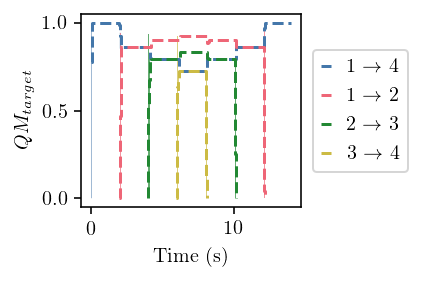

In [14]:
data = aggQM.xs("mean", level="name", axis=1)
dataMin = aggQM.xs("min", level="name", axis=1)
dataMax = aggQM.xs("max", level="name", axis=1)

def rearrangeNcs(df):
    # rearrange to have ncs14 first
    cols = df.columns.tolist()
    cols = [cols[1]] + [cols[0]] + cols[2:]
    return df[cols]

data = rearrangeNcs(data)
dataMin = rearrangeNcs(dataMin)
dataMax = rearrangeNcs(dataMax)

labelMap = { "ncs14" : "1 $\\rightarrow$ 4",
             "ncs12" : "1 $\\rightarrow$ 2",
             "ncs23" : "2 $\\rightarrow$ 3",
             "ncs34" : "3 $\\rightarrow$ 4"
           }

#display(data)

#fig, ax = plt.subplots(figsize=(18.5*cm,14.5*cm))
#fig, ax = plt.subplots(figsize=(6.0*cm,4.5*cm))
fig, ax = plt.subplots(figsize=(5.0*cm,4.5*cm))
#fig, ax = plt.subplots(figsize=(6.0*cm,3.0*cm))

for i,col in enumerate(data.columns):
    plot_data = data[col].dropna()
    min_data = dataMin[col].dropna()
    max_data = dataMax[col].dropna()
    ax.plot(plot_data.index.values - 30, plot_data.values, label=labelMap[col], drawstyle='steps-post', linestyle='dashed')
    ax.fill_between(min_data.index.values - 30, min_data.values, max_data.values, facecolor=colormap[i], alpha=0.7, step='post')

handles, labels = ax.get_legend_handles_labels()
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: float(t[0]), reverse=True))
#labels = np.vectorize(lambda x: '{0.magnitude:6.2f}{0.units:~}'.format((Q_(x) * ureg.second).to_compact()))(labels)

ncol=4
#legend = plot.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5))
legend = ax.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5), handlelength=0.5)
#legend = ax.legend(handles, labels, loc='lower center', bbox_to_anchor= (0.5, 1.01), ncol=2, handlelength=2)
#align_legend_labels(legend, ncol)

ax.set_xlabel('Time (s)')
ax.set_ylabel('$QM_{target}$')
#ax.set_xlim(11.9,12.4)
#ax.set_xlim(3.9,4.4)

plt.savefig(plot_prefix + 'manyflows_qm.pdf', bbox_inches='tight')
plt.show()

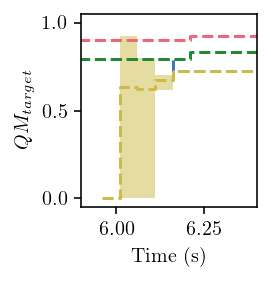

In [15]:
fig, ax = plt.subplots(figsize=(4.0*cm,4.5*cm))

for i,col in enumerate(data.columns):
    plot_data = data[col].dropna()
    min_data = dataMin[col].dropna()
    max_data = dataMax[col].dropna()
    ax.plot(plot_data.index.values - 30, plot_data.values, label=labelMap[col], drawstyle='steps-post', linestyle='dashed')
    ax.fill_between(min_data.index.values - 30, min_data.values, max_data.values, facecolor=colormap[i], alpha=0.5, step='post')

handles, labels = ax.get_legend_handles_labels()

ax.set_xlabel('Time (s)')
ax.set_ylabel('$QM_{target}$')
ax.set_xlim(5.9,6.4)

plt.savefig(plot_prefix + 'manyflows_qm_crop.pdf', bbox_inches='tight')
plt.show()

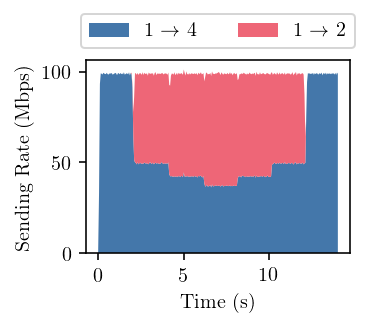

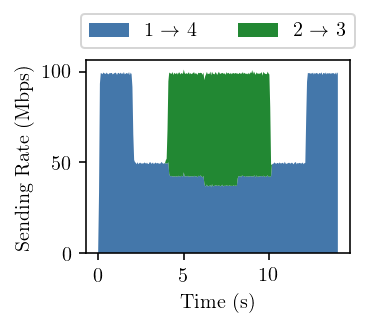

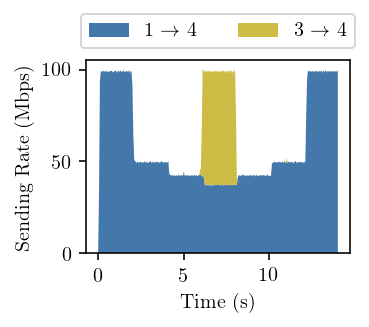

In [16]:
data = pd.DataFrame(aggRate.xs(0, level="name", axis=1))
pairings = [
    (1, "12", ["ncs14", "ncs12"]),
    (2, "23", ["ncs14", "ncs23"]),
    (3, "34", ["ncs14", "ncs34"]),
]

#display(data)

for pair in pairings:
    subset = data[pair[2]]
    subset = subset.rename(columns={"ncs14" : "1 $\\rightarrow$ 4",
                                    "ncs12" : "1 $\\rightarrow$ 2",
                                    "ncs23" : "2 $\\rightarrow$ 3",
                                    "ncs34" : "3 $\\rightarrow$ 4"})
    
    plot, ax = plt.subplots(figsize=(6.0*cm,4.5*cm))

    #for col in data.columns:
    #    plot_data = data[col].dropna()
    #    ax.stackplot(plot_data.index.values - 30, plot_data.values / 10**6#), label=col)
    ax.stackplot(subset.index.values - 30, subset.values.T / 10**6, labels=subset.columns, colors=[colormap[0], colormap[pair[0]]])

    handles, labels = ax.get_legend_handles_labels()
    #labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: float(t[0]), reverse=True))
    #labels = np.vectorize(lambda x: '{0.magnitude:6.2f}{0.units:~}'.format((Q_(x) * ureg.second).to_compact()))(labels)

    #ncol=4
    #legend = plot.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5))
    legend = ax.legend(handles, labels, loc='lower center', bbox_to_anchor= (0.5, 1.01), ncol=2)
    #align_legend_labels(legend, ncol)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Sending Rate (Mbps)')

    plt.savefig(plot_prefix + 'manyflows_rate_' + pair[1] + '.pdf', bbox_inches='tight')
    plt.show()

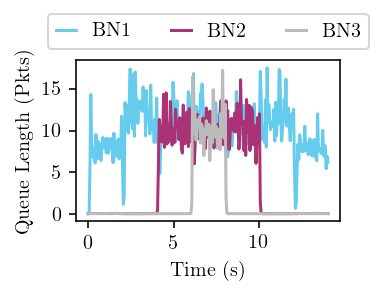

In [17]:
data = time_series_queue.xs("sum", level="name", axis=1)

#display(data)

data = data.rename(columns={"ic1" : "BN1",
                            "ic2" : "BN2",
                            "ic3" : "BN3"})

#plot, ax = plt.subplots(figsize=(8.5*cm,4.5*cm))
plot, ax = plt.subplots(figsize=(6.0*cm,3.75*cm))

for i in range(0,4):
    ax.plot([], [])

for col in data.columns:
    plot_data = data[col].dropna()
    ax.plot(plot_data.index.values - 30, plot_data.values, label=col)

handles, labels = ax.get_legend_handles_labels()
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: float(t[0]), reverse=True))
#labels = np.vectorize(lambda x: '{0.magnitude:6.2f}{0.units:~}'.format((Q_(x) * ureg.second).to_compact()))(labels)

#ncol=4
#legend = plot.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5))
#legend = ax.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5))
legend = ax.legend(handles, labels, loc='lower center', bbox_to_anchor= (0.5, 1.01), ncol=3, handlelength=1)
#align_legend_labels(legend, ncol)

#ax.set_ylim(top=1.1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Queue Length (Pkts)')

plt.savefig(plot_prefix + 'manyflows_queue.pdf', bbox_inches='tight')
plt.show()

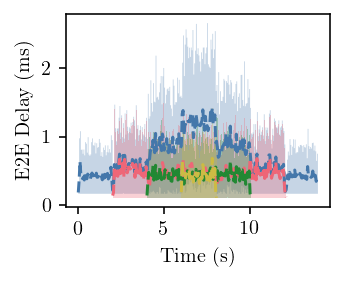

In [20]:
data = aggDelay.xs("mean", level="name", axis=1)
dataMin = aggDelay.xs("min", level="name", axis=1)
dataMax = aggDelay.xs("max", level="name", axis=1)

def rearrangeNcs(df):
    # rearrange to have ncs14 first
    cols = df.columns.tolist()
    cols = [cols[1]] + [cols[0]] + cols[2:]
    return df[cols]

data = rearrangeNcs(data)
dataMin = rearrangeNcs(dataMin)
dataMax = rearrangeNcs(dataMax)

labelMap = { "ncs14" : "1 $\\rightarrow$ 4",
             "ncs12" : "1 $\\rightarrow$ 2",
             "ncs23" : "2 $\\rightarrow$ 3",
             "ncs34" : "3 $\\rightarrow$ 4"
           }

#display(data)

#fig, ax = plt.subplots(figsize=(8.5*cm,4.5*cm))
fig, ax = plt.subplots(figsize=(6.0*cm,4.5*cm))

for i,col in enumerate(data.columns):
    plot_data = data[col].dropna()
    min_data = dataMin[col].dropna()
    max_data = dataMax[col].dropna()
    ax.plot(plot_data.index.values - 30, plot_data.values * 1000, label=labelMap[col], linestyle='dashed')
    ax.fill_between(min_data.index.values - 30, min_data.values * 1000, max_data.values * 1000, facecolor=colormap[i], alpha=0.3, step='post')

handles, labels = ax.get_legend_handles_labels()
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: float(t[0]), reverse=True))
#labels = np.vectorize(lambda x: '{0.magnitude:6.2f}{0.units:~}'.format((Q_(x) * ureg.second).to_compact()))(labels)

ncol=4
#legend = plot.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5))
#legend = ax.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5))
#align_legend_labels(legend, ncol)

ax.set_xlabel('Time (s)')
ax.set_ylabel('E2E Delay (ms)')
#ax.set_xlim(5.9,6.2)

plt.savefig(plot_prefix + 'manyflows_delay.pdf', bbox_inches='tight')
plt.show()